# Assignment 4: Ranking & Evaluation

## General guidelines

This notebook contains considerable amount of code to help you complete this assignment. Your task is to implement any missing parts of the code and answer any questions (if exist) within this notebook. This will require understanding the existing code, may require reading about packages being used, reading additional resources, and maybe even going over your notes from class 😱

**Evaluation and auto-grading**: Your submissions will be evaluated using both automatic and manual grading. Code parts for implementation are marked with a comment `# YOUR CODE HERE`, and usually followed by cell(s) containing automatic tests that evaluate the correctness of your answer. Additionaly, staff will manually assess your submission. Any automatic tests that did not run due to your notebook timing out **will automatically receive 0 points**. The execution time excludes initial data download, which will already exist in the testing environment. The staff reserves the right to **modify any grade provided by the auto-grader** as well as to **execute additional tests not provided to you**. It is also important to note that **auto-graded cells only result in full or no credit**. In other words, you must pass all tests implemented in a test cell in order to get the credit for it, and passing some, but not all, of the tests in a test cell will not earn you any points for that cell. 

**Submission**: Unless specified otherwise, you need to upload this notebook file **with your ID as the file name**, e.g. 012345678.ipynb, to the assignment on Moodle.

# Tasks

In this assignment, we are going to build a complete retrieval system using the inverted index (assignment 2)

**Your tasks in this assignment are:**

1. (25 Points) Implement ranking using TF-IDF and BM25.
2. (20 Points) Implement search/retrieval using the inverted index. Implement compound ranking based on title and body. 
4. (15 Points) Using weighting of title and body scores. Provide three examples of mistakes that the model is making and explanations for why, and describe how you will change the model based on these observations.
5. (25 Points) Implement the multiple metrics, including precision, recall, NDCG, MRR, and more.
6. (5 Points) Optimize your ranking function for MAP@100 using the training set. Validate that the final submitted model passes the test of MAP@100 on the test set. 
7. (10 Points) Plot graphs. First, plot metrics scores for the different queries. Second, plot metrics scores with varying values of k. (e.g., MRR@1, MRR@3, MRR@5, etc.')







# Imports

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict,Counter
import re
import nltk
import pickle
import numpy as np
nltk.download('stopwords')

from nltk.corpus import stopwords
from tqdm import tqdm
import operator
from itertools import islice,count
from contextlib import closing

import json
from io import StringIO
from pathlib import Path
from operator import itemgetter
import pickle
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
!tar -xf cran.tar.gz

--2021-12-22 21:11:32--  http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506960 (495K) [application/gzip]
Saving to: ‘cran.tar.gz.4’

cran.tar.gz.4       100%[===================>] 495.08K   387KB/s    in 1.3s    

2021-12-22 21:11:34 (387 KB/s) - ‘cran.tar.gz.4’ saved [506960/506960]



## Tasks 1: Implement ranking using TF-IDF and BM25 (25 points).
In this task, you need to implement TF-IDF and BM25. At this point, for simplicity, we do not use an inverted index. However, later on in this assignment, we will.

Implementation remarks:
* TF-IDF: use [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To deal with stopwords use the argument `stop_words`. (5 points)

TfidfVectorizer suggests handling with additional parameters, as you can read in the documentation. Make sure you read about them.

* Cosine Similarity: use [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html). (5 points)

* BM25: Implement a BM25 version according to the provided skeleton **without the use of packages**. 10 points as follows:
    * Prepare the data and filter stopwords. (5 points)
    * Implement two functions at BM25 class. (5 points)

* Ranking: implement topN functionallity (5 points)

**Later in this assignment, we will write code for TF-IDF and BM25 that utilize the inverted index.**

In [ ]:
# set of documents
data = ['The sky is blue and we can see the blue sun.',
        'The sun is bright and yellow.',
        'here comes the blue sun',
        'Lucy in the sky with diamonds and you can see the sun in the sky',
        'sun sun blue sun here we come',
        'Lucy likes blue bright diamonds']

### TF-IDF

**YOUR TASK (5 POINTS):**  Complete the implementation of `tf_idf_scores`, which calculates the tfidf for each word in a single document utilizing TfidfVectorizer via sklearn.

In [ ]:
def tf_idf_scores(data):
    """
    This function calculates the tfidf for each word in a single document utilizing TfidfVectorizer via sklearn.

    Parameters:
    -----------
      data: list of strings.
    
    Returns:
    --------
      Two objects as follows:
                                a) DataFrame, documents as rows (i.e., 0,1,2,3, etc'), terms as columns ('bird','bright', etc').
                                b) TfidfVectorizer object.

    """
    # YOUR CODE HERE
    vect_tfidf = TfidfVectorizer(stop_words='english')
    df = pd.DataFrame(data=vect_tfidf.fit_transform(data).toarray(), 
                      index=range(len(data)),
                      columns=vect_tfidf.get_feature_names_out())
    return df, vect_tfidf
df_tfidfvect, tfidfvectorizer = tf_idf_scores(data)

In [ ]:
type(df_tfidfvect)

pandas.core.frame.DataFrame

In [ ]:
#tests
assert df_tfidfvect.shape[1] == 10 and df_tfidfvect.shape[0] == 6
assert 'is' not in df_tfidfvect.columns and 'we' not in df_tfidfvect.columns
assert 'sun' in df_tfidfvect.columns and 'yellow' in df_tfidfvect.columns
assert round(df_tfidfvect.max(),3).max() == 0.798
assert np.count_nonzero(df_tfidfvect) == 21
assert type(tfidfvectorizer) == TfidfVectorizer



Now, upon existing TF-IDF matrix we are seeking for the similarity for given new queries. 
First we need to convert the **new** queries into a vector format. Therefore we use transform instead of fit_transform.

Next, we would like to calculate the cosine similarity between queires and documents.



In [ ]:
queries = ['look the the blue sky', 'He likes the blue the sun','Lucy likes blue sky with diamonds']
queries_vector = tfidfvectorizer.transform(queries)



Now, lets calculate the cosine similarity utilizing sklearn.

**YOUR TASK (5 POINTS):**  Complete the implementation of `cosine_sim_using_sklearn`.
You need to compute the similarity between the queries and the given documents.

In [ ]:
def cosine_sim_using_sklearn(queries,tfidf):
    """
    In this function you need to utilize the cosine_similarity function from sklearn.
    You need to compute the similarity between the queries and the given documents.
    This function will return a DataFrame in the following shape: (# of queries, # of documents).
    Each value in the DataFrame will represent the cosine_similarity between given query and document.
    
    Parameters:
    -----------
      queries: sparse matrix represent the queries after transformation of tfidfvectorizer.
      documents: sparse matrix represent the documents.
      
    Returns:
    --------
      DataFrame: This function will return a DataFrame in the following shape: (# of queries, # of documents).
      Each value in the DataFrame will represent the cosine_similarity between given query and document.
    """
    # YOUR CODE HERE
    return pd.DataFrame(cosine_similarity(queries, tfidf))

cosine_sim_df = cosine_sim_using_sklearn(queries_vector,df_tfidfvect)

In [ ]:
# tests for cosine similarity
assert cosine_sim_df.shape[0] == len(queries)
assert cosine_sim_df.shape[1] == len(data)
assert (abs(cosine_sim_df)>1).any().any() == False
assert np.count_nonzero(cosine_sim_df) == 16
assert round(cosine_sim_df.max(),3).max() == 0.888

### BM25
In this section we will create a class of Best Match 25 (BM25)

To use BM25 we will need to following parameters:

* $k1$ and $b$ - free parameters
* $f(t_i,D)$ - term frequency of term $t_i$ in document $D$
* |$D$|- is the length of the document $D$ in terms 
* $avgdl$ -  average document length
* $IDF$ - which is calculted as follows: $ln(\frac{(N-n(t_i)+0.5}{n(t_i)+0.5)}+1)$, where $N$ is the total number of documents in the collection, and $n(t_i)$ is the number of documents containing $t_i$ (e.g., document frequency (df)).

As a reminder of the data looks like this


In [ ]:
data

['The sky is blue and we can see the blue sun.',
 'The sun is bright and yellow.',
 'here comes the blue sun',
 'Lucy in the sky with diamonds and you can see the sun in the sky',
 'sun sun blue sun here we come',
 'Lucy likes blue bright diamonds']

**Note:** While using TF-IDF from sklearn we used the `stop_words` argument. 

**It is not the case when working with BM25 without any package.**
Therefore, we need to filter the data and clean it. We will do so utilizing NLTK stopwords

In [ ]:
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
stopwords_frozen = frozenset(stopwords.words('english'))
def tokenize(text):
    """
    This function aims in tokenize a text into a list of tokens. Moreover, it filter stopwords.
    
    Parameters:
    -----------
    text: string , represting the text to tokenize.    
    
    Returns:
    -----------
    list of tokens (e.g., list of tokens).
    """
    list_of_tokens =  [token.group() for token in RE_WORD.finditer(text.lower()) if token.group() not in stopwords_frozen]    
    return list_of_tokens


clean_data = [tokenize(doc) for doc in data]



Now let's find all the parameters needed for our toy example.
**Later on we will need to gather this information from the inverted index.**

**YOUR TASK (5 POINTS):**  Complete the implementation of `bm25_preprocess`.
This function goes through the data and saves relevant information for the calculation of bm25. 

In [ ]:
def bm25_preprocess(data):
    """
    This function goes through the data and saves relevant information for the calculation of bm25. 
    Specifically, in this function, we will create 3 objects that gather information regarding document length, term frequency and
    document frequency.
    Parameters
    -----------
    data: list of lists. Each inner list is a list of tokens. 
    Example of data: 
    [
        ['sky', 'blue', 'see', 'blue', 'sun'],
        ['sun', 'bright', 'yellow'],
        ['comes', 'blue', 'sun'],
        ['lucy', 'sky', 'diamonds', 'see', 'sun', 'sky'],
        ['sun', 'sun', 'blue', 'sun'],
        ['lucy', 'likes', 'blue', 'bright', 'diamonds']
    ]
    
    Returns:
    -----------
    three objects as follows:
                a) doc_len: list of integer. Each element represents the length of a document.
                b) tf: list of dictionaries. Each dictionary corresponds to a document as follows:
                                                                    key: term
                                                                    value: normalized term frequency (by the length of document)

                                                                                               
                c) df: dictionary representing the document frequency as follows:
                                                                    key: term
                                                                    value: document frequency
    """      
    doc_len = [len(i) for i in data]
    tf = []
    df = {}

    # iterates through words in documents
    for doc in data:
      doc_dict = dict()
      for i in doc:
        if i not in doc_dict.keys():
          doc_dict[i] = 0
        doc_dict[i] += 1
      for term in doc_dict.keys():
        doc_dict[term] = doc_dict[term]/len(doc)
        if term not in df.keys():
          df[term] = 0
        df[term] += 1
      tf.append(doc_dict)

    # YOUR CODE HERE
    return doc_len,tf,df

In [ ]:
# tests - preprocess data for naive bm25
doc_len,tf,df = bm25_preprocess(clean_data)
assert df['blue'] == 4
assert sum(tf[0].values()) == 1
assert sum(doc_len) > sum(df.values())


**YOUR TASK (5 POINTS):** Complete the implementation of `calc_idf` and `_score` at the BM25 class.


In [ ]:
import math

class BM25:
    """
    Best Match 25.

    Parameters to tune
    ----------
    k1 : float, default 1.5

    b : float, default 0.75

    Attributes
    ----------
    tf_ : list[dict[str, int]]
        Term Frequency per document. So [{'hi': 1}] means
        the first document contains the term 'hi' 1 time.
        The frequnecy is normilzied by the max term frequency for each document.

    doc_len_ : list[int]
        Number of terms per document. So [3] means the first
        document contains 3 terms. 
        
    df_ : dict[str, int]
        Document Frequency per term. i.e. Number of documents in the
        corpus that contains the term.       

    avg_doc_len_ : float
        Average number of terms for documents in the corpus.

    idf_ : dict[str, float]
        Inverse Document Frequency per term.
    """

    def __init__(self,doc_len,df,tf=None,k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1
        self.tf_ = tf
        self.doc_len_ = doc_len
        self.df_ = df
        self.N_ = len(doc_len)
        self.avgdl_ = sum(doc_len) / len(doc_len)        
        

    def calc_idf(self,query):
        """
        This function calculate the idf values according to the BM25 idf formula for each term in the query.
        
        Parameters:
        -----------
        query: list of token representing the query. For example: ['look', 'blue', 'sky']
        
        Returns:
        -----------
        idf: dictionary of idf scores. As follows: 
                                                    key: term
                                                    value: bm25 idf score
        """
        # YOUR CODE HERE
        idf = dict()
        curr_df = dict()
        for term in query:
          if term in self.df_.keys():
            curr_df[term] = self.df_[term]
          else:
            curr_df[term] = 0
          numerator = len(self.doc_len_) - curr_df[term] + 0.5
          denominator = curr_df[term] + 0.5
          idf[term] = np.log((numerator/denominator) + 1)
        return idf
        

    def search(self, queries):
        """
        This function use the _score function to calculate the bm25 score for all queries provided.
        
        Parameters:
        -----------
        queries: list of lists. Each inner list is a list of tokens. For example:
                                                                                    [
                                                                                        ['look', 'blue', 'sky'],
                                                                                        ['likes', 'blue', 'sun'],
                                                                                        ['likes', 'diamonds']
                                                                                    ]

        Returns:
        -----------
        list of scores of bm25
        """
        scores = []
        for query in queries:            
            scores.append([self._score(query, doc_id) for doc_id in range(self.N_)])
        return scores

    

In [ ]:
class BM25(BM25):

    def _score(self, query, doc_id):
        """
        This function calculate the bm25 score for given query and document.
        
        Parameters:
        -----------
        query: list of token representing the query. For example: ['look', 'blue', 'sky']
        doc_id: integer, document id.
        
        Returns:
        -----------
        score: float, bm25 score.
        """
        # YOUR CODE HERE

        query_tfs = Counter(query)
        BM_idf = self.calc_idf(query)
        new_tfs = dict()

        sum = 0
        for term in query:
          if term in self.tf_[doc_id].keys():
            new_tfs[term] = self.tf_[doc_id][term]
          else:
            new_tfs[term] = 0

          doc_tf = new_tfs[term]
          normalizer = self.k1*(1 - self.b + self.b*((self.doc_len_[doc_id])/self.avgdl_))
          sum += query_tfs[term] * (self.k1 + 1) * doc_tf/(doc_tf + normalizer) * BM_idf[term]
        return sum



Let's create a new instance of BM25, and calculte its score for all queries. 
Pay attetnion - we need to tokenize and filter the stopwords from the original queries.

In [ ]:
bm25 = BM25(tf=tf,doc_len=doc_len,df=df)

# Remove tokenizing and remove stopwords from queries
clean_queries = [tokenize(query) for query in queries]
BM25_res = bm25.search(clean_queries)
BM25_df = pd.DataFrame(data = BM25_res,index = [query_id for query_id in range(len(clean_queries))] ,columns = [doc_id for doc_id in range(len(data))])


In [ ]:
BM25_df

,0,1,2,3,4,5
0,0.500277,0.000000,0.252476,0.388536,0.121050,0.121050
1,0.284261,0.137807,0.390283,0.049217,0.283631,0.543090
2,0.500277,0.000000,0.252476,0.808788,0.121050,1.107265


In [ ]:
# tests BM25
assert BM25_df[0][0] == BM25_df[0][2]
assert BM25_df[2][0] == BM25_df[2][2]
assert BM25_df[3][0] != BM25_df[3][2]
assert (BM25_df>1).any().any() == True
assert (BM25_df==0).any().any() == True
assert BM25_df.sum().argmax() == 5
assert BM25_df.sum().argmin() == 1
assert sum(bm25.search([['amit','livne'],['lucy','likes','blue','bright','diamonds']])[0]) == 0
assert (bm25.search([['amit','livne'],['lucy','likes','blue','bright','diamonds']])[1][-1] > BM25_df[5][2])
assert (bm25.search([['amit','livne'],['lucy','likes','blue','bright','diamonds']])[1][2] > BM25_df[1][2])

We can now search for top-N documents for each query

**YOUR TASK (5 POINTS):**  Complete the implementation of `top_N_documents`, which sort and filter the top N docuemnts (by score) for each query.


In [ ]:
def top_N_documents(df,N):
    """
    This function sort and filter the top N docuemnts (by score) for each query.
    
    Parameters
    ----------    
    df: DataFrame (queries as rows, documents as columns)
    N: Integer (how many document to retrieve for each query)    

    Returns:
    ----------
    top_N: dictionary is the following stracture:
          key - query id.
          value - sorted (according to score) list of pairs lengh of N. Eac pair within the list provide the following information (doc id, score)
    """    
    # YOUR CODE HERE
    keys = list(df.T.columns)
    top_dict = dict()
    for key in keys:
      top_dict[key] = []
      for doc_id in range(len(df.columns)):
        top_dict[key].append((doc_id, df[doc_id][key]))
      top_dict[key].sort(key= lambda x: x[1], reverse=True)
      top_dict[key] = top_dict[key][:N]
    return top_dict

In [ ]:
# test - topN documents
top_2_docs = top_N_documents(cosine_sim_df,2)
top_10_docs = top_N_documents(cosine_sim_df,10)
assert len(top_2_docs[0]) == 2
assert len(top_2_docs[0][0]) == 2
assert (top_2_docs[0][0][1] > top_N_documents(cosine_sim_df,2)[0][1][1])
assert (top_10_docs[0][-1][-1] == 0)
assert (top_10_docs[0][-1][-1] != top_10_docs[1][-1][-1])
assert (top_10_docs[0][0][-1] != top_10_docs[1][0][-1])


The top-N functionality runs on all document and create a large DataFrame. What will happen if the number of documents is much larger? 
Will this function be efficient? 

Next, we will build an inverted index (like we did in assignment two). Then, we will use the inverted index utilizing the posting list to create a candidate list of documents per query. 
Therefore, we will narrow the documents relevant per query.

Only then will we calculate the TF-IDF and cosine similarity.

## Tasks 2: Implement compound ranking based on title and body using the inverted index (20 points).

In order to do so, we will first perform parsing followed by building an Inverted index.
Then we will create a searching and ranking mechanism.

In this task, you will use Cranfield Corpus. But we need to do some setups in advance. 

**Setups:**

*Make sure you upload the carnfield.py file. attached with this assignment*

First, we will load it into the following data structures:

* cran_txt_data - list of tuples. An example is provided below. Hold information regards the carnfield dataset.
* cran_qry_rel_data - list of tuples. An example is provided below. Holds information regards the queries.

We have already done all the load and preprocessing of the data for you.

We split the queries data into the training and test sets.
Next, we build two inverted indices (one built upon title information and the second on the text\body of the documents). 

**After finishing the setups, we implement the ranking mechanism (TF-IDF and BM25 build upon inverted index).**











### Cranfield Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>


**Parsing**

For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/experiments/blob/master/00_Data/CranfieldCorpus.ipynb) or, for parsing in general, read [this guide](https://pragmalingu.de/docs/guides/how-to-parse). An overview of the format of the files can be found here: [Data Sets](https://pragmalingu.de/docs/guides/data-comparison)

In [ ]:
import carnfield

cran_txt_data,cran_qry_rel_data = carnfield.main()

### Data seperation
In real-world scenarios, we do not know all the queries in advance. Thus, we are familiar with some queries and can use them to tune the parameters of our model (e.g., the k and b for BM25 or term that appears at least n times within the data, etc.'). We will split the queries into two sets to simulate this scenario: Train and Test.

You can and should use the data from the train set to tune the parameters of your retrieval model. **You should not use the test data for tuning.**


The test data should be used to evaluate your model according to the metrics in the following section (e.g., precision, recall etc.')

Example of cran_txt_data:

In [ ]:
#list(islice(cran_txt_data.items(), 1))

Example of cran_qry_rel_data. 
For each query id you can see the question and the relevance assessments is a list of tuples of relevant document. The tuple structure is as follows: (document id, relevance score). Therefore a tuple such as (184,2) indicates that the document id 184 relevance score is 2.

In [ ]:
#list(islice(cran_qry_rel_data.items(), 1))

Split to train and test queries

In [ ]:
cran_qry_rel_data_train = list(islice(cran_qry_rel_data.items(), 0,180))
cran_qry_rel_data_test = list(islice(cran_qry_rel_data.items(), 180,225))

Next, we will use the inverted index from assignment 2 (with some minor adaptations).
We save a dictionary named `DL`, which fetches the document length of each document.

Upon using the index functionality of add_doc, `DL` needs to be updated as well.

### Inverted index (code from assignment 2)

#### Helper classes (code from assignment 2)

In [ ]:
# Let's start with a small block size of 30 bytes just to test things out. 
BLOCK_SIZE = 199998

class MultiFileWriter:
    """ Sequential binary writer to multiple files of up to BLOCK_SIZE each. """
    def __init__(self, base_dir, name):
        self._base_dir = Path(base_dir)
        self._name = name
        self._file_gen = (open(self._base_dir / f'{name}_{i:03}.bin', 'wb') 
                          for i in count())
        self._f = next(self._file_gen)
    
    def write(self, b):
      locs = []
      while len(b) > 0:
        pos = self._f.tell()
        remaining = BLOCK_SIZE - pos
        # if the current file is full, close and open a new one.
        if remaining == 0:  
          self._f.close()
          self._f = next(self._file_gen)
          pos, remaining = 0, BLOCK_SIZE
        self._f.write(b[:remaining])
        locs.append((self._f.name, pos))
        b = b[remaining:]
      return locs

    def close(self):
      self._f.close()

class MultiFileReader:
  """ Sequential binary reader of multiple files of up to BLOCK_SIZE each. """
  def __init__(self):
    self._open_files = {}

  def read(self, locs, n_bytes):
    b = []
    for f_name, offset in locs:
      if f_name not in self._open_files:
        self._open_files[f_name] = open(f_name, 'rb')
      f = self._open_files[f_name]
      f.seek(offset)
      n_read = min(n_bytes, BLOCK_SIZE - offset)
      b.append(f.read(n_read))
      n_bytes -= n_read
    return b''.join(b)
  
  def close(self):
    for f in self._open_files.values():
      f.close()

  def __exit__(self, exc_type, exc_value, traceback):
    self.close()
    return False 

In [ ]:
TUPLE_SIZE = 6       # We're going to pack the doc_id and tf values in this 
                     # many bytes.
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer

DL = {}  # We're going to update and calculate this after each document. This will be usefull for the calculation of AVGDL (utilized in BM25) 
class InvertedIndex:  
  def __init__(self, docs={}):
    """ Initializes the inverted index and add documents to it (if provided).
    Parameters:
    -----------
      docs: dict mapping doc_id to list of tokens
    """
    # stores document frequency per term
    self.df = Counter()
    # stores total frequency per term
    self.term_total = Counter()
    # stores posting list per term while building the index (internally), 
    # otherwise too big to store in memory.
    self._posting_list = defaultdict(list)
    # mapping a term to posting file locations, which is a list of 
    # (file_name, offset) pairs. Since posting lists are big we are going to
    # write them to disk and just save their location in this list. We are 
    # using the MultiFileWriter helper class to write fixed-size files and store
    # for each term/posting list its list of locations. The offset represents 
    # the number of bytes from the beginning of the file where the posting list
    # starts. 
    self.posting_locs = defaultdict(list)
    
    for doc_id, tokens in docs.items():
      self.add_doc(doc_id, tokens)

  def add_doc(self, doc_id, tokens):
    """ Adds a document to the index with a given `doc_id` and tokens. It counts
        the tf of tokens, then update the index (in memory, no storage 
        side-effects).
    """
    DL[(doc_id)] = DL.get(doc_id,0) + (len(tokens))
    w2cnt = Counter(tokens)
    self.term_total.update(w2cnt)
    max_value = max(w2cnt.items(), key=operator.itemgetter(1))[1]    
    # frequencies = {key: value/max_value for key, value in frequencies.items()}
    for w, cnt in w2cnt.items():        
        self.df[w] = self.df.get(w, 0) + 1                
        self._posting_list[w].append((doc_id, cnt))


  def write(self, base_dir, name):
    """ Write the in-memory index to disk and populate the `posting_locs`
        variables with information about file location and offset of posting
        lists. Results in at least two files: 
        (1) posting files `name`XXX.bin containing the posting lists.
        (2) `name`.pkl containing the global term stats (e.g. df).
    """
    #### POSTINGS ####
    self.posting_locs = defaultdict(list)
    with closing(MultiFileWriter(base_dir, name)) as writer:
      # iterate over posting lists in lexicographic order
      for w in sorted(self._posting_list.keys()):
        self._write_a_posting_list(w, writer, sort=True)
    #### GLOBAL DICTIONARIES ####
    self._write_globals(base_dir, name)

  def _write_globals(self, base_dir, name):
    with open(Path(base_dir) / f'{name}.pkl', 'wb') as f:
      pickle.dump(self, f)

  def _write_a_posting_list(self, w, writer, sort=False):
    # sort the posting list by doc_id
    pl = self._posting_list[w]
    if sort:
      pl = sorted(pl, key=itemgetter(0))
    # convert to bytes    
    b = b''.join([(int(doc_id) << 16 | (tf & TF_MASK)).to_bytes(TUPLE_SIZE, 'big')
                  for doc_id, tf in pl])
    # write to file(s)
    locs = writer.write(b)
    # save file locations to index
    self.posting_locs[w].extend(locs) 

  def __getstate__(self):
    """ Modify how the object is pickled by removing the internal posting lists
        from the object's state dictionary. 
    """
    state = self.__dict__.copy()
    del state['_posting_list']
    return state

  @staticmethod
  def read_index(base_dir, name):
    with open(Path(base_dir) / f'{name}.pkl', 'rb') as f:
      return pickle.load(f)

  @staticmethod
  def delete_index(base_dir, name):
    path_globals = Path(base_dir) / f'{name}.pkl'
    path_globals.unlink()
    for p in Path(base_dir).rglob(f'{name}_*.bin'):
      p.unlink()
  

In this assignment we will generate two indexes. 
One for titles and one for body (e.g., text).
First, we need to tokenize the title and body textual information (e.g., text). 
Note: it can take several minutes to tokenize it.

Next, we will create two seperated indexes.


In [ ]:
cran_txt_data_titles = {k: tokenize(v['title']) for k,v in cran_txt_data.items()}
cran_txt_data_text = {k: tokenize(v['text']) for k,v in cran_txt_data.items()}


Next, we need to preprocess the text of the queries for both training and test sets.

In [ ]:
cran_txt_query_text_train = {q[0]: tokenize(q[1]['question']) for q in cran_qry_rel_data_train}
cran_txt_query_text_test = {q[0]: tokenize(q[1]['question']) for q in cran_qry_rel_data_test}

#### Creating and writing the index

In [ ]:
index_titles = InvertedIndex(docs=cran_txt_data_titles)
index_text = InvertedIndex(docs=cran_txt_data_text)

In [ ]:
# create directories for the different indices 
!mkdir body_index title_index

mkdir: cannot create directory ‘body_index’: File exists
mkdir: cannot create directory ‘title_index’: File exists


In [ ]:
index_titles.write('title_index','title')
index_text.write('body_index','body')

### Reading data from posting (code taken from assignment 2)

In [ ]:
class InvertedIndex(InvertedIndex):
  
  def posting_lists_iter(self):
    """ A generator that reads one posting list from disk and yields 
        a (word:str, [(doc_id:int, tf:int), ...]) tuple.
    """
    with closing(MultiFileReader()) as reader:
      for w, locs in self.posting_locs.items():
        # read a certain number of bytes into variable b
        b = reader.read(locs, self.df[w] * TUPLE_SIZE)
        posting_list = []
        # convert the bytes read into `b` to a proper posting list.
        
        for i in range(self.df[w]):
          doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
          tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
          posting_list.append((doc_id, tf))
        
        yield w, posting_list

In [ ]:
def get_posting_gen(index):
    """
    This function returning the generator working with posting list.
    
    Parameters:
    ----------
    index: inverted index    
    """
    words, pls = zip(*index.posting_lists_iter())
    return words,pls

**Example of use**

First, we will load the title index. 

Next, we will search for a given term in both lists (words, and pls)

Remineder: pls is the information from the posting list.
Each value within the `words` list has a corresponding value in the `pls` list.
The value within a `pls` list is a list of tuples. Each tuple in the following format (x,y). Where x represent the document id, and `y` represent the occurence of the term in the document. 

In this example we are seeking the first term in the `words` list, and we can observe the is appears in 4 different documents. 
Moreover, we can observe that in document 807 it appears twice.

In [ ]:
idx_title = InvertedIndex.read_index('title_index', 'title')
idx_body = InvertedIndex.read_index('body_index', 'body')
# read posting lists from disk
words, pls = zip(*idx_title.posting_lists_iter())

Let's check for example the document number `807`. 
We needed its document length (DL) which is suppose to be the length of its title + the length of the text of the document. 
Let's verify it.

In [ ]:
#Let's check the title of document 807
cran_txt_data_titles['807']

['ground',
 'measurements',
 'shock',
 'wave',
 'noise',
 'supersonic',
 'bomber',
 'airplanes',
 'altitude',
 'range',
 '000',
 '000',
 'feet']

Clearly `000` should not appear twice.
Let have a second look on the original document and understand weather it's a mistake within a tokenization step or in the original title.

In [ ]:
cran_txt_data['807']['title']

' ground measurements of the shock wave noise from supersonic bomber airplanes in the altitude range from 30,000 to 50,000 feet . '

As we could have guessed, the token `000` does not appear twice in this document.

**Reminder: garbage in = garbage out.**

**For this assignment, it is ok to leave it as is. However, verify this part when you are working on your project.**

In [ ]:
assert DL['807'] == len(cran_txt_data_titles['807']) + len(cran_txt_data_text['807'])
assert len(DL) == len(cran_txt_data_titles)


### Ranking
In this section, you will be given a query or queries and return a ranked list of documents to retrieve.
In this assignment, we are experimenting with two methods. TF-IDF and BM25. 

**We will use the inverted index in order to do so and will not utilize the whole corpus in advance.**

#### TF-IDF for carnfield data (10 points)

Bellow cells contain the following functions: 

*   *generate_query_tfidf_vector* - Generate a vector representing the query
*   *get_candidate_documents_and_scores* - Generate a dictionary representing a pool of candidate documents for a given query.
*   *generate_document_tfidf_matrix* - Generate a DataFrame of tfidf scores for a given query.
*   *cosine_similarity* - Calculate the cosine similarity for each candidate document in D and a given query (e.g., Q). **You will impelement this function (5 points)**

*   *get_top_n* - Sort and return the highest N documents according to the cosine similarity score.

*   *get_topN_score_for_queries* - Generate a dictionary that gather for every query its topN score. **You will impelement this function (5 points)**

In [ ]:
def generate_query_tfidf_vector(query_to_search,index):
    """ 
    Generate a vector representing the query. Each entry within this vector represents a tfidf score.
    The terms representing the query will be the unique terms in the index.

    We will use tfidf on the query as well. 
    For calculation of IDF, use log with base 10.
    tf will be normalized based on the length of the query.    

    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.'). 
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']

    index:           inverted index loaded from the corresponding files.
    
    Returns:
    -----------
    vectorized query with tfidf scores
    """
    
    epsilon = .0000001
    total_vocab_size = len(index.term_total)
    Q = np.zeros((total_vocab_size))
    term_vector = list(index.term_total.keys())    
    counter = Counter(query_to_search)
    for token in np.unique(query_to_search):
        if token in index.term_total.keys(): #avoid terms that do not appear in the index.               
            tf = counter[token]/len(query_to_search) # term frequency divded by the length of the query
            df = index.df[token]            
            idf = math.log((len(DL))/(df+epsilon),10) #smoothing
            
            try:
                ind = term_vector.index(token)
                Q[ind] = tf*idf                    
            except:
                pass
    return Q
    

In [ ]:
def get_candidate_documents_and_scores(query_to_search,index,words,pls):
    """
    Generate a dictionary representing a pool of candidate documents for a given query. This function will go through every token in query_to_search
    and fetch the corresponding information (e.g., term frequency, document frequency, etc.') needed to calculate TF-IDF from the posting list.
    Then it will populate the dictionary 'candidates.'
    For calculation of IDF, use log with base 10.
    tf will be normalized based on the length of the document.
    
    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.'). 
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']

    index:           inverted index loaded from the corresponding files.

    words,pls: generator for working with posting.
    Returns:
    -----------
    dictionary of candidates. In the following format:
                                                               key: pair (doc_id,term)
                                                               value: tfidf score. 
    """
    candidates = {}
    N = len(DL)        
    for term in np.unique(query_to_search):        
        if term in words:            
            list_of_doc = pls[words.index(term)]                        
            normlized_tfidf = [(doc_id,(freq/DL[str(doc_id)])*math.log(N/index.df[term],10)) for doc_id, freq in list_of_doc]           
                        
            for doc_id, tfidf in normlized_tfidf:
                candidates[(doc_id,term)] = candidates.get((doc_id,term), 0) + tfidf               
        
    return candidates

In [ ]:
def generate_document_tfidf_matrix(query_to_search,index,words,pls):
    """
    Generate a DataFrame `D` of tfidf scores for a given query. 
    Rows will be the documents candidates for a given query
    Columns will be the unique terms in the index.
    The value for a given document and term will be its tfidf score.
    
    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.'). 
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']

    index:           inverted index loaded from the corresponding files.

    words,pls: generator for working with posting.
    Returns:
    -----------
    DataFrame of tfidf scores.
    """
    
    total_vocab_size = len(index.term_total)
    candidates_scores = get_candidate_documents_and_scores(query_to_search,index,words,pls) #We do not need to utilize all document. Only the docuemnts which have corrspoinding terms with the query.
    unique_candidates = np.unique([doc_id for doc_id, freq in candidates_scores.keys()])
    D = np.zeros((len(unique_candidates), total_vocab_size))
    D = pd.DataFrame(D)
    
    D.index = unique_candidates
    D.columns = index.term_total.keys()

    for key in candidates_scores:
        tfidf = candidates_scores[key]
        doc_id, term = key    
        D.loc[doc_id][term] = tfidf

    return D
     


**YOUR TASK (5 POINTS):** Complete the implementation of `cosine_similarity`. This function calculate the cosine similarity for each candidate document in D and a given query (e.g., Q) and return a dictionary of cosine similary scores.

**Note:** for this task you cannot use sklearn. However, you can use pandas or numpy.

In [ ]:
def cosine_similarity(D,Q):
    """
    Calculate the cosine similarity for each candidate document in D and a given query (e.g., Q).
    Generate a dictionary of cosine similarity scores 
    key: doc_id
    value: cosine similarity score
    
    Parameters:
    -----------
    D: DataFrame of tfidf scores.

    Q: vectorized query with tfidf scores
    
    Returns:
    -----------
    dictionary of cosine similarity score as follows:
                                                                key: document id (e.g., doc_id)
                                                                value: cosine similarty score.
    """
    # YOUR CODE HERE

    # get doc sizes for normalization:
    doc_sizes = np.linalg.norm(D, axis=1)
    query_size = np.linalg.norm(Q)
    cos_normalizers = doc_sizes*query_size
    dot_prod = np.dot(D, Q)  # supposed to give a 1d 
    cos_sims = dot_prod/cos_normalizers
    sim_dict = dict()
    for ind, doc_id in enumerate(D.T.columns):
      sim_dict[doc_id] = cos_sims[ind]
    return sim_dict
    

In [ ]:
def get_top_n(sim_dict,N=3):
    """ 
    Sort and return the highest N documents according to the cosine similarity score.
    Generate a dictionary of cosine similarity scores 
   
    Parameters:
    -----------
    sim_dict: a dictionary of similarity score as follows:
                                                                key: document id (e.g., doc_id)
                                                                value: similarity score. We keep up to 5 digits after the decimal point. (e.g., round(score,5))

    N: Integer (how many documents to retrieve). By default N = 3
    
    Returns:
    -----------
    a ranked list of pairs (doc_id, score) in the length of N.
    """
    
    return sorted([(doc_id,round(score,5)) for doc_id, score in sim_dict.items()], key = lambda x: x[1],reverse=True)[:N]



**YOUR TASK (5 POINTS)**: Complete the implementation of `get_topN_score_for_queries`. This function generate a dictionary that gather for every query its topN score, based on cosine similarity.

In [ ]:
def get_topN_score_for_queries(queries_to_search,index,N=3):
    """ 
    Generate a dictionary that gathers for every query its topN score.
    
    Parameters:
    -----------
    queries_to_search: a dictionary of queries as follows: 
                                                        key: query_id
                                                        value: list of tokens.
    index:           inverted index loaded from the corresponding files.    
    N: Integer. How many documents to retrieve. This argument is passed to the topN function. By default N = 3, for the topN function. 
    
    Returns:
    -----------
    return: a dictionary of queries and topN pairs as follows:
                                                        key: query_id
                                                        value: list of pairs in the following format:(doc_id, score). 
    """
    # YOUR CODE HERE
    words, p_lst = get_posting_gen(index)
    
    # inits dict with empty lists
    top_n_dict = dict(zip(queries_to_search.keys(), [[]]*len(queries_to_search.keys())))
    
    for query_id, toks in queries_to_search.items():
      doc_tfidf_mat = generate_document_tfidf_matrix(toks, index, words, p_lst)
      query_tfidf = generate_query_tfidf_vector(toks,index)
      cos_sim_dict = cosine_similarity(doc_tfidf_mat, query_tfidf)
      top_n_dict[query_id] = get_top_n(cos_sim_dict, N)
    return top_n_dict


In [ ]:
#tests 
tfidf_queries_score_train = get_topN_score_for_queries(cran_txt_query_text_train,idx_title)
assert len(tfidf_queries_score_train)==180
assert 0 not in tfidf_queries_score_train.keys()
assert len(tfidf_queries_score_train[5])==3
assert tfidf_queries_score_train[172][0][1] == tfidf_queries_score_train[172][1][1]
assert tfidf_queries_score_train[14][0][1] == tfidf_queries_score_train[172][1][1]

For query 172 we can observe two document with cosine similarity score of 1. Let's have a glance on this query and documents for making sure it makes sense

In [ ]:
print('relevnt documents and tfidf score for query number 172 :',tfidf_queries_score_train[172])
print('query: ' ,cran_txt_query_text_train[172])
print('docuemnt 320: ', cran_txt_data_titles['320'])
print('docuemnt 320: ', cran_txt_data_titles['321'])
print('docuemnt 322: ', cran_txt_data_titles['322'])

relevnt documents and tfidf score for query number 172 : [(320, 1.0), (321, 1.0), (322, 1.0)]
query:  ['solution', 'blasius', 'problem', 'three-point', 'boundary', 'conditions']
docuemnt 320:  ['comment', 'improved', 'numerical', 'solution', 'blasius', 'problem', 'three-point', 'boundary', 'conditions']
docuemnt 320:  ['improved', 'numerical', 'solution', 'blasius', 'problem', 'three-point', 'boundary', 'conditions']
docuemnt 322:  ['numerical', 'solution', 'blasius', 'problem', 'three-point', 'boundary', 'conditions']


#### BM25 for carnfield data (10 points)
As a reminder:

To use BM25 we will need to following parameters:

* $k1$ and $b$ - free parameters
* $f(t_i,D)$ - term frequency of term $t_i$ in document $D$
* |$D$|- is the length of the document $D$ in terms 
* $avgdl$ -  average document length
* $IDF$ - which is calculted as follows: $ln(\frac{(N-n(t_i)+0.5}{n(t_i)+0.5)}+1)$, where $N$ is the total number of documents in the collection, and $n(t_i)$ is the number of documents containing $t_i$ (e.g., document frequency (df)).

Now, we will use the inverted index to fetch this information.

**We need to check only documents which are 'candidates' for a given query.**

We can create a simpler version of get candidate functions. (We do not need to calculate the TFIDF scores)

In [ ]:
def get_candidate_documents(query_to_search,index,words,pls):
    """
    Generate a dictionary representing a pool of candidate documents for a given query. 
    
    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.'). 
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']

    index:           inverted index loaded from the corresponding files.

    words,pls: generator for working with posting.
    Returns:
    -----------
    list of candidates. In the following format:
                                                               key: pair (doc_id,term)
                                                               value: tfidf score. 
    """
    candidates = []    
    for term in np.unique(query_to_search):
        if term in words:        
            current_list = (pls[words.index(term)])                
            candidates += current_list    
    return np.unique(candidates)


**YOUR TASK (10 POINTS):** Complete the implementation of `search` at the BM25 class.
Differently, from previous implememntation, this time you should check only documents which are 'candidates' for a given query. 


In [ ]:
import math
from itertools import chain
import time
# When preprocessing the data have a dictionary of document length for each document saved in a variable called `DL`.
class BM25_from_index:
    """
    Best Match 25.    
    ----------
    k1 : float, default 1.5

    b : float, default 0.75

    index: inverted index
    """

    def __init__(self,index,k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1
        self.index = index
        self.N = len(DL)
        self.AVGDL = sum(DL.values())/self.N
        self.words, self.pls = zip(*self.index.posting_lists_iter())        

    def calc_idf(self,list_of_tokens):
        """
        This function calculate the idf values according to the BM25 idf formula for each term in the query.
        
        Parameters:
        -----------
        query: list of token representing the query. For example: ['look', 'blue', 'sky']
        
        Returns:
        -----------
        idf: dictionary of idf scores. As follows: 
                                                    key: term
                                                    value: bm25 idf score
        """        
        idf = {}        
        for term in list_of_tokens:            
            if term in self.index.df.keys():
                n_ti = self.index.df[term]
                idf[term] = math.log(1 + (self.N - n_ti + 0.5) / (n_ti + 0.5))
            else:
                pass                             
        return idf
        

    def search(self, queries,N=3):
        """
        This function calculate the bm25 score for given query and document.
        We need to check only documents which are 'candidates' for a given query. 
        This function return a dictionary of scores as the following:
                                                                    key: query_id
                                                                    value: a ranked list of pairs (doc_id, score) in the length of N.
        
        Parameters:
        -----------
        query: list of token representing the query. For example: ['look', 'blue', 'sky']
        doc_id: integer, document id.
        
        Returns:
        -----------
        score: float, bm25 score.
        """
        # YOUR CODE HERE
        query_cand_dict = dict()
        for q_id, query in queries.items():  
            top_n_dict={}
            self.idf = self.calc_idf(query) 
            
            for doc_key in get_candidate_documents(query,self.index,self.words,self.pls):
              top_n_dict[doc_key] = self._score(query,doc_key)
            query_cand_dict[q_id] = get_top_n(top_n_dict,N)
            
        return query_cand_dict

    def _score(self, query, doc_id):
        """
        This function calculate the bm25 score for given query and document.
        
        Parameters:
        -----------
        query: list of token representing the query. For example: ['look', 'blue', 'sky']
        doc_id: integer, document id.
        
        Returns:
        -----------
        score: float, bm25 score.
        """        
        score = 0.0        
        doc_len = DL[str(doc_id)]        
             
        for term in query:
            if term in self.index.term_total.keys():                
                term_frequencies = dict(self.pls[self.words.index(term)])                
                if doc_id in term_frequencies.keys():            
                    freq = term_frequencies[doc_id]
                    numerator = self.idf[term] * freq * (self.k1 + 1)
                    denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.AVGDL)
                    score += (numerator / denominator)
        return score

In [ ]:
bm25_title = BM25_from_index(idx_title)
bm25_queries_score_train = bm25_title.search(cran_txt_query_text_train)

In [ ]:
#tests
assert len(bm25_queries_score_train)==180
assert 0 not in bm25_queries_score_train.keys()
assert len(bm25_queries_score_train[5])==3
assert bm25_queries_score_train[172][0][1] != bm25_queries_score_train[172][1][1]
assert bm25_queries_score_train[14][0][1] != bm25_queries_score_train[172][1][1]

## Task 3: Using weights of title and body scores (15 points)

Reminder: we are building on the training set.
Later you need to optimize the parameters and run the best parameters on the test set.

Now we will experiment with two sets of results. 
The first corresponds to results from the title index. 
The second corresponds to the results from the body index.

We need to merge them into a single result set.

**YOUR TASK (10 POINTS):** Complete the implementation of `merge_results`.
This function merge and sort documents retrieved by its weighte score (e.g., title and body).


In [ ]:
def merge_results(title_scores,body_scores,title_weight=0.5,text_weight=0.5,N = 3):
    """
    This function merge and sort documents retrieved by its weighte score (e.g., title and body). 

    Parameters:
    -----------
    title_scores: a dictionary build upon the title index of queries and tuples representing scores as follows: 
                                                                            key: query_id
                                                                            value: list of pairs in the following format:(doc_id,score)
                
    body_scores: a dictionary build upon the body/text index of queries and tuples representing scores as follows: 
                                                                            key: query_id
                                                                            value: list of pairs in the following format:(doc_id,score)
    title_weight: float, for weigted average utilizing title and body scores
    text_weight: float, for weigted average utilizing title and body scores
    N: Integer. How many document to retrieve. This argument is passed to topN function. By default N = 3, for the topN function. 
    
    Returns:
    -----------
    dictionary of querires and topN pairs as follows:
                                                        key: query_id
                                                        value: list of pairs in the following format:(doc_id,score). 
    """
    query_topNpairs = dict()
    for title_qid in title_scores.keys():  # what if there are text qids that arent found?
      id_scores = []
      TextID_Scores_dict = dict(body_scores[title_qid]) # dict of text scores for this query
      TitleID_Scores_dict = dict(title_scores[title_qid]) # dict of title scores for this query
      for title_did, title_score in title_scores[title_qid]: # iterates over list of title scores
        
        # if there is a match, calc weighted sum
        try: 
          text_score = TextID_Scores_dict[title_did]
          weighed_score = title_score*title_weight + text_score*text_weight
          id_scores.append((title_did, weighed_score))
        except:   # if the title didn't find a match, append it alone
          score = title_score*title_weight
          id_scores.append((title_did, score))
      
      for text_did, text_score in body_scores[title_qid]: # iterates over list of title scores
        
        # if there is a match, ignore it
        try: 
          title_score = TitleID_Scores_dict[text_did]
          continue
        except:   # if the title didn't find a match, append it alone
          score = text_score*text_weight
          id_scores.append((text_did, score))
      id_scores.sort(key=lambda x:x[1],reverse=True)
      query_topNpairs[title_qid] = id_scores[:N]
    return query_topNpairs
      





In [ ]:
bm25_title = BM25_from_index(idx_title)
bm25_body = BM25_from_index(idx_body)

bm25_queries_score_train_title = bm25_title.search(cran_txt_query_text_train)
bm25_queries_score_train_body = bm25_body.search(cran_txt_query_text_train)


In [ ]:
#tests
w1,w2 = 0.5, 0.5
w3,w4 = 0.25,0.75

half_and_half = merge_results(bm25_queries_score_train_title,bm25_queries_score_train_body,w1,w2)        
assert len(half_and_half[2]) == 3
assert type(half_and_half) == dict
assert type(half_and_half[2]) == list
assert len(half_and_half) == 180
assert half_and_half[2][0][1] == 0.5 * (bm25_queries_score_train_title[2][-1][1]+ bm25_queries_score_train_body[2][0][1])

quarter_and_three_quarters = merge_results(bm25_queries_score_train_title,bm25_queries_score_train_body,0.25,0.75)        

assert quarter_and_three_quarters[2][0][1] == (w3 * bm25_queries_score_train_title[2][-1][1] + w4 * bm25_queries_score_train_body[2][0][1])
assert {k for k,v in half_and_half[16]} != {k for k,v in quarter_and_three_quarters[16]}
assert len({k for k,v in half_and_half[16]}.union({k for k,v in quarter_and_three_quarters[16]})) < (len({k for k,v in half_and_half[16]}) + len({k for k,v in quarter_and_three_quarters[16]}))



**YOUR TASK (5 POINTS):** provide three examples of mistakes that the model is making and explanations for why, and describe how you will change the model based on these observations.

In [ ]:
# YOUR EXAMPLES HERE #

assert True

## Task 4: Implement several evaluation metrics (25 points).

At this task, you will need to write the multiple metrics **(without using pre-defined packages)** and evaluate the results on the test set.


Reminder: 
* `carn_queries_train` holds the queries for the training set
* `cran_qry_rel_data_train` holds the relevant data for each query in the training set.
* `carn_queries_test` holds the queries for the test set
* `cran_qry_rel_data_test` holds the relevant data for each query in the test set.

In [ ]:
def intersection(l1,l2):      
    """
    This function perform an intersection between two lists.

    Parameters
    ----------
    l1: list of documents. Each element is a doc_id.
    l2: list of documents. Each element is a doc_id.

    Returns:
    ----------
    list with the intersection (without duplicates) of l1 and l2
    """
    return list(set(l1)&set(l2))

**YOUR TASK (25 POINTS):** Complete the implementation of the below functions:


In [ ]:
def recall_at_k(true_list,predicted_list,k=40):
    """
    This function calculate the recall@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, recall@k with 3 digits after the decimal point.
    """      
    # YOUR CODE HERE
    return round(len(intersection(true_list, predicted_list[:k]))/len(true_list), 3)

In [ ]:
def precision_at_k(true_list,predicted_list,k=40):    
    """
    This function calculate the precision@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, precision@k with 3 digits after the decimal point.
    """      
    # YOUR CODE HERE
    return  round(len(intersection(true_list, predicted_list[:k]))/k, 3)


In [ ]:
def r_precision(true_list,predicted_list):
    """
    This function calculate the r-precision metric. No `k` parameter is used.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score    
    
    Returns:
    -----------
    float, r-precision with 3 digits after the decimal point.
    """    
    # YOUR CODE HERE
    r = len(true_list)
    k_prec = len(intersection(true_list,predicted_list[:r]))
    return round(k_prec/r, 3)

In [ ]:
def reciprocal_rank_at_k(true_list,predicted_list,k=40):
    """
    This function calculate the reciprocal_rank@k metric.        
    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------    
    float, reciprocal rank@k with 3 digits after the decimal point.
    """   
    # YOUR CODE HERE
    for ind, d_id in enumerate(predicted_list):
      if ind >= k: break

      if d_id in true_list:
        return round(1/(ind + 1), 3)

    return 0.0


In [ ]:
def fallout_rate(true_list,predicted_list,k=40):    
    """
    This function calculate the fallout_rate@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, fallout_rate@k with 3 digits after the decimal point.
    """ 
    # YOUR CODE HERE
    tot_irrel = max(predicted_list)
    if tot_irrel > max(true_list):
      bigger = max(true_list)
    
    tot_irrel -= len(true_list)
    
    predicted_list = predicted_list[:k]
    num_irrel= len(predicted_list) - len(intersection(true_list,predicted_list))
    return(round(num_irrel/tot_irrel,3))




In [ ]:
def f_score(true_list,predicted_list,k=40):
    """
    This function calculate the f_score@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, f-score@k with 3 digits after the decimal point.
    """   
    # YOUR CODE HERE
    recall = recall_at_k(true_list, predicted_list, k)
    precision = precision_at_k(true_list, predicted_list, k)
    
    if recall == 0 and precision == 0:
      return 0.0

    return round(2*precision*recall/(recall + precision), 3)

In [ ]:
def average_precision(true_list,predicted_list,k=40):
    """
    This function calculate the average_precision@k metric.(i.e., precision in every recall point).     

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, average precision@k with 3 digits after the decimal point.
    """
    # YOUR CODE HERE
    cnt, prec_sum = 0, 0
    for i, id in enumerate(predicted_list):
      if i >= k: break

      if id in true_list:
        prec_sum += precision_at_k(true_list,predicted_list,i+1)
        cnt+=1
      
    if not cnt:
      return 0.0

    return(round(prec_sum/cnt,3))


In [ ]:
 def ndcg_at_k(true_tuple_list,predicted_list,k=40):
    """
    This function calculate the ndcg@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, ndcg@k with 3 digits after the decimal point.
    """ 
    def dcg(predicted_lst, true_lst, true_dict):
      cum_sum = 0
      for id in predicted_lst:
        if type(id) is tuple:
          id = id[0]
        if id in true_lst:
          if cum_sum == 0:
            cum_sum = true_dict[id]
          else:
            curr_rel=true_dict[id]
            cum_sum = curr_rel/np.log2(cum_sum + 1)
      return cum_sum
    
    predicted_list = predicted_list[:k]
    true_tuple_list = sorted(true_tuple_list, key=lambda x: x[1],reverse=True)
    rel_predicted = intersection(predicted_list, [tup[0] for tup in true_tuple_list])
    true_dict=dict(true_tuple_list)

    if not rel_predicted:
      return 0
    
    dcg_oracle = dcg(true_tuple_list, rel_predicted, true_dict)
    dcg_predicted = dcg(predicted_list, rel_predicted, true_dict)

    return(round(dcg_predicted/dcg_oracle, 3))

    
    



  

Next, we define `evaluate`. A function that calculates multiple metrics and returns a dictionary with metrics scores across different queries.

In [ ]:
def evaluate(true_relevancy,predicted_relevancy,k,print_scores=True):
    """
    This function calculates multiple metrics and returns a dictionary with metrics scores across different queries.
    Parameters
    -----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})
     
    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]            
            
    k: integer, a number to slice the length of the predicted_list
    
    print_scores: boolean, enable/disable a print of the mean value of each metric.
    
    Returns:
    -----------
    a dictionary of metrics scores as follows: 
                                                        key: metric name
                                                        value: list of metric scores. Each element corresponds to a given query.
    """    

    recall_lst = []
    precision_lst = []
    f_score_lst = []
    r_precision_lst = []
    reciprocal_rank_lst = []
    avg_precision_lst = []
    fallout_rate_lst = []
    ndcg_lst = []
    metrices = {'recall@k':recall_lst,
                'precision@k':precision_lst,
                'f_score@k': f_score_lst,
                'r-precision': r_precision_lst,
                'MRR@k':reciprocal_rank_lst,
                'MAP@k':avg_precision_lst,
                'fallout@k':fallout_rate_lst,
                'ndcg@k':ndcg_lst}
    
    for query_id, query_info in tqdm(true_relevancy):
        predicted = [doc_id for doc_id, score in predicted_relevancy[query_id]]    
        ground_true = [int(doc_id) for doc_id, score in query_info['relevance_assessments']]
    
        recall_lst.append(recall_at_k(ground_true,predicted,k=k))
        precision_lst.append(precision_at_k(ground_true,predicted,k=k))
        f_score_lst.append(f_score(ground_true,predicted,k=k))
        r_precision_lst.append(r_precision(ground_true,predicted))
        reciprocal_rank_lst.append(reciprocal_rank_at_k(ground_true,predicted,k=k))
        avg_precision_lst.append(average_precision(ground_true,predicted,k=k))
        fallout_rate_lst.append(fallout_rate(ground_true,predicted,k=k))
        ndcg_lst.append(ndcg_at_k(query_info['relevance_assessments'],predicted,k=k))

    if print_scores:
        for name,values in metrices.items():
                print(name,sum(values)/len(values))

    return metrices    
    
 

Let's examine the metrices scores according to the test set

In [ ]:
# For demonstration we will use N=100. 

N = 100
bm25_queries_score_test_title = bm25_title.search(cran_txt_query_text_test,N=N)
bm25_queries_score_test_body = bm25_body.search(cran_txt_query_text_test,N=N)
half_and_half_test = merge_results(bm25_queries_score_test_title,bm25_queries_score_test_body,N=N)  

In [ ]:
#tests
ground_true = [int(doc_id) for doc_id, score in cran_qry_rel_data_test[0][1]['relevance_assessments']]
predicted = [doc_id for doc_id, score in half_and_half_test[181]] 
assert precision_at_k(ground_true,predicted,k=20) == 0.15
assert recall_at_k(ground_true,predicted,k=20) == 0.5
assert reciprocal_rank_at_k(ground_true,predicted,k=4) == 0.0
assert reciprocal_rank_at_k(ground_true,predicted,k=5) == 0.2
assert r_precision(ground_true,predicted) == 0.333
assert f_score(ground_true,predicted,3) == f_score(ground_true,predicted,4)
assert f_score(ground_true,predicted,4) < f_score(ground_true,predicted,5)
assert ndcg_at_k(cran_qry_rel_data_test[0][1]['relevance_assessments'],predicted,4) == reciprocal_rank_at_k(ground_true,predicted,k=4)
assert ndcg_at_k(cran_qry_rel_data_test[0][1]['relevance_assessments'],predicted,5) > 0
assert fallout_rate(ground_true,predicted,4000) == fallout_rate(ground_true,predicted,40000)
assert fallout_rate(ground_true,predicted,1) == 0.001
assert average_precision(ground_true,predicted,5) == 0.2

ground_true = [int(doc_id) for doc_id, score in cran_qry_rel_data_test[1][1]['relevance_assessments']]
predicted = [doc_id for doc_id, score in half_and_half_test[182]] 
assert precision_at_k(ground_true,predicted,k=4) == 0.5
assert recall_at_k(ground_true,predicted,k=4) == 0.667
assert reciprocal_rank_at_k(ground_true,predicted,k=4) == 1
assert r_precision(ground_true,predicted) == 0.667
assert ndcg_at_k(cran_qry_rel_data_test[1][1]['relevance_assessments'],predicted,16) == 1
assert average_precision(ground_true,predicted,17) == round((precision_at_k(ground_true,predicted,k=1)+precision_at_k(ground_true,predicted,k=2)+precision_at_k(ground_true,predicted,k=17))/3,3)

## Task 5: Optimization (5 points)
Optimize your ranking function for MAP@N using the training set.
Try 2 different (not default) combinations of the free parameters and try them with 2 different weight (not included equal weights) on the merge of title and body indecis. 

**Using the training set only.**

Than, choose you final model and evalute it using MAP@30 on the test set.

**YOUR TASK (5 POINTS):** Complete the implementation of the `grid_search_models`


In [ ]:
def grid_search_models(data,true_relevancy,bm25_param_list,w_list,N,idx_title,idx_body):

    """
    This function is performing a grid search upon different combination of parameters.
    The parameters can be BM25 parameters (i.e., bm25_param_list) or different weights (i.e., w_list).
    
    Parameters
    ----------
    data: dictionary as follows: 
                            key: query_id
                            value: list of tokens

    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})     
        
    bm25_param_list: list of tuples. Each tuple represent (k,b1) values.

    w_list: list of tuples. Each tuple represent (title_weight,body_weight).    
    N: Integer. How many document to retrieve. 
    
    idx_title: index build upon titles
    idx_body:  index build upon bodies
    ----------
    return: dictionary as follows:
                            key: tuple indiciating the parameters examined in the model (k1,b,title_weight,body_weight)
                            value: MAP@N score
    """
    models = {}
    # YOUR CODE HERE
    for k, b1 in bm25_param_list:
      title = BM25_from_index(idx_title,k1=k,b=b1)        
      body = BM25_from_index(idx_body,k1=k,b=b1)
      test_title_score = title.search(data,N=N)
      test_body_score = body.search(data,N=N)
      for t_weight,b_weight in w_list:
        merge_res = merge_results(test_title_score,test_body_score,title_weight=t_weight,text_weight=b_weight,N=N)
        test_matrices = evaluate(true_relevancy,merge_res,k=N,print_scores=False) 
        models[(k,b1, t_weight, b_weight)] = test_matrices["MAP@k"]
    return models

parameters_list = [(1.4,0.8),(1.6,0.7)]
weights_list = [(0.35,0.65),(0.2,0.8)]
N = 30
grid_models = grid_search_models(cran_txt_query_text_train,cran_qry_rel_data_train,parameters_list,weights_list,N,idx_title,idx_body)



100%|██████████| 180/180 [00:00<00:00, 5817.25it/s]


In [ ]:
#tests
# get key for max value in dictioary
k1,b,title_w,body_w = max(grid_models, key=grid_models.get)

bm25_title = BM25_from_index(idx_title,k1=k1,b=b)        
bm25_body = BM25_from_index(idx_body,k1=k1,b=b)
bm25_queries_score_test_title = bm25_title.search(cran_txt_query_text_test,N=N)
bm25_queries_score_test_body = bm25_body.search(cran_txt_query_text_test,N=N)
merge_res = merge_results(bm25_queries_score_test_title,bm25_queries_score_test_body,title_weight=title_w,text_weight=body_w,N=N)
test_metrices = evaluate(cran_qry_rel_data_test,merge_res,k=N,print_scores=False) 

100%|██████████| 45/45 [00:00<00:00, 3737.72it/s]


In [ ]:
       
assert round(sum(test_metrices['MAP@k'])/len(test_metrices['MAP@k']),3) > 0.52
assert len(test_metrices['MAP@k']) == 45
assert max(test_metrices['MAP@k']) == 1
assert min(test_metrices['MAP@k']) == 0
assert len(grid_models) >= 4

## Task 6: Plots (10 points)

**YOUR TASK (5 POINTS):** Complete the implementation of `plot_metric_with_differnt_k_values`. 
Plot different values of precision and recall (utilizing different k values) for a given query

In [ ]:
def plot_metric_with_differnt_k_values(true_relevancy,predicted_relevancy,metrices_names,k_values):    
    """
    This function plot a for each given metric its value depands on k_values as line chart.
    This function does not return any value.

    Parameters
    ----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})

    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]

    metrices_names: list of string representing the metrices to plot. For example: ['precision@k','recall@k','f_score@k']

    k_values: list of integer of different k values. For example [1,3,5]

    returns: 
    plot values in format : 
    
    statistics[metric_name] = [values , k_values]

    """
    statistics = {}

    # makes list of dicts mapping materics to their value, for each k
    metrics_lst = [evaluate(true_relevancy,predicted_relevancy,k,False) for k in k_values]

    for m_name in metrices_names:
      
      # makes values list and calculates means
      means = [np.mean(metrics_lst[k][m_name]) for k in range(len(k_values))]
      
      # inserts mean, k_val pair into statistics dict
      statistics[m_name] = [means,k_values]
      
      # plots metric
      plt.plot(k_values, means , label = m_name) 
    
    # create plot

    plt.legend(loc='upper right',bbox_to_anchor=(1.55,0))
    plt.xlabel("k")
    plt.ylabel("Average value")
    plt.show()


    return statistics


**YOUR TASK (5 POINTS):** Complete the implementation of `plot_metric_different_quieries`. 
Plot different values of metrices (utilizing same k values) for different queries.

In [ ]:
def plot_metric_different_quieries(true_relevancy,predicted_relevancy,metrices_names,k):
    """
    This function plot for each given metric its value across all queries.
    This function does not return any value.

    Parameters
    ----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})

    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]

    metrices_names: list of string representing the metrices to plot. For example: ['precision@k','recall@k','f_score@k']
    k: integer, a number to slice the length of the predicted_list.
    
    """
    relevant_ids = [id[0] for id in true_relevancy]
    metrics = evaluate(true_relevancy,predicted_relevancy,k,False)
    
    for m_name in metrices_names:
        plt.plot(relevant_ids, metrics[m_name], label = m_name)
    
    plt.xlabel("Query")
    plt.legend(loc='right')
    plt.ylabel("Value")
    plt.show()

    


100%|██████████| 45/45 [00:00<00:00, 4760.72it/s]


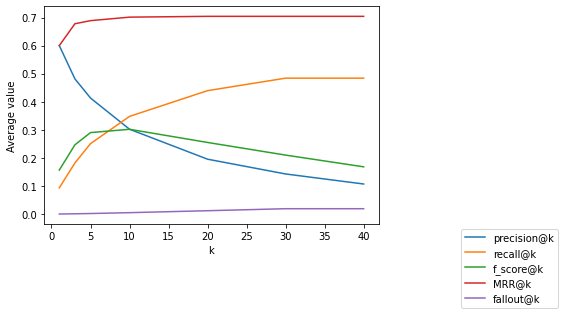

In [ ]:
k_values = [1,3,5,10,20,30,40]
metrices_names = ['precision@k','recall@k','f_score@k','MRR@k','fallout@k']
statistics_of_differnt_k = plot_metric_with_differnt_k_values(cran_qry_rel_data_test,merge_res,metrices_names,k_values=k_values)

In [ ]:
assert  all(statistics_of_differnt_k['precision@k'][0][i-1] > statistics_of_differnt_k['precision@k'][0][i] for i in range(1, len(statistics_of_differnt_k['precision@k'])))
assert  all(statistics_of_differnt_k['recall@k'][0][i-1] < statistics_of_differnt_k['recall@k'][0][i] for i in range(1, len(statistics_of_differnt_k['recall@k'])))
assert  all(statistics_of_differnt_k['MRR@k'][0][i-1] <= statistics_of_differnt_k['MRR@k'][0][i] for i in range(1, len(statistics_of_differnt_k['MRR@k'])))
assert  all(statistics_of_differnt_k['fallout@k'][0][i-1] <= statistics_of_differnt_k['fallout@k'][0][i] for i in range(1, len(statistics_of_differnt_k['fallout@k'])))

100%|██████████| 45/45 [00:00<00:00, 3050.11it/s]


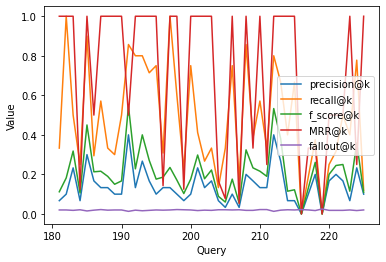

In [ ]:
plot_metric_different_quieries(cran_qry_rel_data_test,merge_res,metrices_names,k=N)

In [ ]:
assert True